# Machine Learning

In [1]:
#import necessary libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
import seaborn as sns
import datetime as dt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
#import calendar as cal
#import workalendar
from workalendar.america import Brazil
from datetime import date
from sklearn.cross_validation import train_test_split
%store -r orders_v2

C:\Users\R2D2\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Machine learning library/functions
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
np.random.seed(42)
from sklearn import linear_model
import sklearn.linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# Additional librariers used for modeling and evaluation
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV

C:\Users\R2D2\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


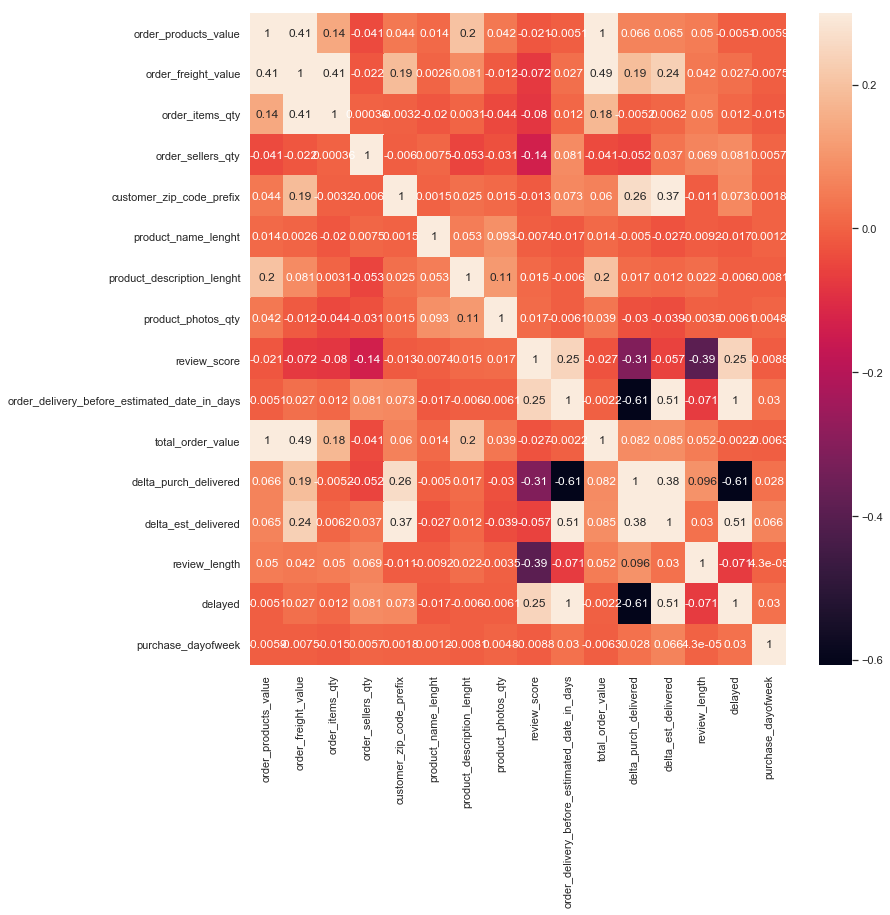

In [3]:
sns.set(font_scale=1)
corr = orders_v2.corr()
#mask = np.zeros_like(corr)
#mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(12,12))
    ax = sns.heatmap(corr, vmax=.3, annot=True)

In [4]:
orders=orders_v2[['order_status', 'order_products_value',
       'order_freight_value', 'order_items_qty', 'order_sellers_qty',
       'order_purchase_timestamp', 'order_aproved_at',
       'order_estimated_delivery_date', 'order_delivered_customer_date',
       'customer_city', 'customer_state',
       'product_category_name','product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'review_score',
       'delta_purch_delivered', 'delta_est_delivered',
       'delayed']]

In [5]:
orders.head()

,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,customer_city,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,review_score,delta_purch_delivered,delta_est_delivered,delayed
0,delivered,349.90,13.84,1,1,2017-01-31 17:19:01,2017-02-01 02:41:21.549551,2017-03-15,2017-02-06 11:04:24.154259,Guaratuba,PR,health beauty,51,625,1,5,5,42,36.0
1,delivered,15.00,15.10,1,1,2017-09-09 19:52:54,2017-09-10 20:03:31.535281,2017-10-02,2017-09-13 20:17:41.296915,Uberlandia,MG,computers accessories,44,1428,2,5,4,22,18.0
2,delivered,238.90,18.00,1,1,2017-01-30 17:00:09,2017-01-30 17:31:25.438253,2017-03-07,2017-02-06 15:43:04.758566,Itapevi,SP,auto,55,637,1,5,6,35,28.0
3,delivered,29.99,18.23,1,1,2018-03-11 18:18:36,2018-03-11 18:30:37.931962,2018-04-03,2018-04-03 20:36:43.778451,Goiania,GO,bed bath table,55,617,1,4,23,22,-1.0
4,delivered,295.99,47.65,1,1,2017-04-20 08:01:08,2017-04-25 08:05:40.405383,2017-05-24,2017-05-04 18:47:45.721758,Recife,PE,furniture decor,49,558,2,5,14,33,19.0


### Features Engineeering:

The first feature I want to engineer is __Estimated Delivery Time in working days__. 
Gets the days between order approval and estimated delivery date. A customer might be unsatisfied if he is told that the estimated time is big.

After reserching on olist site, it was found out that the most common carrier used for delivery does not deliver on Sunday so we have to consider this while calculating the difference between time of purchase and time of estimated delivery.

The second feature I want is __Estimated Delivery Time in working days__.
Gets the days between order approval and delivered customer date. A customer might be more satisfied if he gets the product faster.

The third feature is __Delivery Time Delta in working days__.
The difference between the actual and estimated date. If negative- order was delivered early, if positive - order was delivered late. A customer might be more satisfied if the order arrives sooner than expected, or unhappy if he receives after the deadline.

The fourth feature is __Is Late__. 
Binary variable indicating if the order was delivered after the estimated date.

The fifth feature is __Average Product Value__
Cheaper products might have lower quality, leaving customers unhappy.

The sixth feature is __Order Freight Ratio__
If a customer pays more for freight, he might expect a better service.

The final feature I want to look at is __Purchase Day of Week__ 
Does it affect how happy are the customers? I do not have a lot of intuition behind this step but I have a feeling this feature may be useful.

In [6]:
# load Brazil's working calendar
cal= Brazil()

In [7]:
# function to create new features
def feature_engineering(df):

        df['estimated_delivery_time_wd']=df.apply(lambda x: cal.get_working_days_delta(x.order_aproved_at,x.order_estimated_delivery_date), axis=1)
        df['actual_delivery_time_wd'] = df.apply(lambda x: cal.get_working_days_delta(x.order_aproved_at,x.order_delivered_customer_date), axis=1)
        df['delivery_time_delta_wd'] = df.actual_delivery_time_wd - df.estimated_delivery_time_wd

        df['is_late'] = df.order_delivered_customer_date > df.order_estimated_delivery_date
    
        df['average_product_value'] = df.order_products_value / df.order_items_qty

        df['total_order_value'] = df.order_products_value + df.order_freight_value
        
        df['order_freight_ratio'] = df.order_freight_value / df.order_products_value
        
        df['purchase_dayofweek'] = df.order_purchase_timestamp.dt.dayofweek
        
        df = df.drop(['order_purchase_timestamp', 'order_aproved_at', 'order_estimated_delivery_date', 
                     'order_delivered_customer_date','delta_purch_delivered'], axis=1)
    
        return df

In [8]:
orders_FE1 = feature_engineering(orders)

C:\Users\R2D2\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\R2D2\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\R2D2\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

In [9]:
orders_FE1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
order_status                  100000 non-null object
order_products_value          100000 non-null float64
order_freight_value           100000 non-null float64
order_items_qty               100000 non-null int64
order_sellers_qty             100000 non-null int64
customer_city                 100000 non-null object
customer_state                100000 non-null object
product_category_name         100000 non-null object
product_name_lenght           100000 non-null int64
product_description_lenght    100000 non-null int64
product_photos_qty            100000 non-null int64
review_score                  100000 non-null int64
delta_est_delivered           100000 non-null Int64
delayed                       97595 non-null float64
estimated_delivery_time_wd    100000 non-null int64
actual_delivery_time_wd       100000 non-null int64
delivery_time_delta_wd        100000 non-null int

In [11]:
orders_FE1['delayed']=orders_FE1['delayed'].fillna(0)

In [12]:
# normalize numerical column values
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
normalizer = preprocessing.Normalizer()
numerical = ['order_products_value', 'order_freight_value',
       'order_items_qty', 'order_sellers_qty', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty',
       'delta_est_delivered', 'delayed', 'estimated_delivery_time_wd',
       'actual_delivery_time_wd','delivery_time_delta_wd',
       'average_product_value', 'total_order_value', 'order_freight_ratio',
       'purchase_dayofweek']
X = orders_FE1.loc[:,numerical]
scaled_values = normalizer.fit_transform(X.values)
Xscaled = pd.DataFrame(scaled_values,columns=numerical)

In [13]:
#Xscaled = Xscaled.clip(lower=0, upper=0.6)

In [14]:
Xscaled.head()

,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,product_name_lenght,product_description_lenght,product_photos_qty,delta_est_delivered,delayed,estimated_delivery_time_wd,actual_delivery_time_wd,delivery_time_delta_wd,average_product_value,total_order_value,order_freight_ratio,purchase_dayofweek
0,0.397386,0.015718,0.001136,0.001136,0.057921,0.709821,0.001136,0.047700,0.040886,0.034071,0.003407,-0.030664,0.397386,0.413105,0.000045,0.001136
1,0.010492,0.010562,0.000699,0.000699,0.030776,0.998827,0.001399,0.015388,0.012590,0.011191,0.002098,-0.009093,0.010492,0.021054,0.000704,0.003497
2,0.310386,0.023386,0.001299,0.001299,0.071458,0.827611,0.001299,0.045473,0.036378,0.033780,0.006496,-0.027284,0.310386,0.333773,0.000098,0.000000
3,0.048067,0.029219,0.001603,0.001603,0.088153,0.988913,0.001603,0.035261,-0.001603,0.027247,0.027247,0.000000,0.048067,0.077286,0.000974,0.009617
4,0.378529,0.060938,0.001279,0.001279,0.062664,0.713603,0.002558,0.042202,0.024298,0.025577,0.007673,-0.017904,0.378529,0.439467,0.000206,0.003837


In [15]:
# encode categorized data
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
orders_FE1['order_status'] = lb_make.fit_transform(orders_FE1['order_status'])
orders_FE1['product_category_name'] = lb_make.fit_transform(orders_FE1['product_category_name'])
orders_FE1['customer_city'] = lb_make.fit_transform(orders_FE1['customer_city'])
orders_FE1['customer_state'] = lb_make.fit_transform(orders_FE1['customer_state'])
orders_FE1['is_late'] = lb_make.fit_transform(orders_FE1['is_late'])


In [16]:
orders_FE1.head()

,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,customer_city,customer_state,product_category_name,product_name_lenght,product_description_lenght,...,delta_est_delivered,delayed,estimated_delivery_time_wd,actual_delivery_time_wd,delivery_time_delta_wd,is_late,average_product_value,total_order_value,order_freight_ratio,purchase_dayofweek
0,2,349.90,13.84,1,1,1517,17,43,51,625,...,42,36.0,30,3,-27,0,349.90,363.74,0.039554,1
1,2,15.00,15.10,1,1,3956,10,15,44,1428,...,22,18.0,16,3,-13,0,15.00,30.10,1.006667,5
2,2,238.90,18.00,1,1,1800,25,5,55,637,...,35,28.0,26,5,-21,0,238.90,256.90,0.075345,0
3,2,29.99,18.23,1,1,1437,8,7,55,617,...,22,-1.0,17,17,0,1,29.99,48.22,0.607869,6
4,2,295.99,47.65,1,1,3053,15,39,49,558,...,33,19.0,20,6,-14,0,295.99,343.64,0.160985,3


In [17]:
# concatinate numerical and label endoded categorial columns 
orders_FE1= pd.concat([orders_FE1[['order_status','customer_state','customer_city','product_category_name','review_score','is_late']],Xscaled],axis=1)

In [18]:
orders_FE1.head()

,order_status,customer_state,customer_city,product_category_name,review_score,is_late,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,...,product_photos_qty,delta_est_delivered,delayed,estimated_delivery_time_wd,actual_delivery_time_wd,delivery_time_delta_wd,average_product_value,total_order_value,order_freight_ratio,purchase_dayofweek
0,2,17,1517,43,5,0,0.397386,0.015718,0.001136,0.001136,...,0.001136,0.047700,0.040886,0.034071,0.003407,-0.030664,0.397386,0.413105,0.000045,0.001136
1,2,10,3956,15,5,0,0.010492,0.010562,0.000699,0.000699,...,0.001399,0.015388,0.012590,0.011191,0.002098,-0.009093,0.010492,0.021054,0.000704,0.003497
2,2,25,1800,5,5,0,0.310386,0.023386,0.001299,0.001299,...,0.001299,0.045473,0.036378,0.033780,0.006496,-0.027284,0.310386,0.333773,0.000098,0.000000
3,2,8,1437,7,4,1,0.048067,0.029219,0.001603,0.001603,...,0.001603,0.035261,-0.001603,0.027247,0.027247,0.000000,0.048067,0.077286,0.000974,0.009617
4,2,15,3053,39,5,0,0.378529,0.060938,0.001279,0.001279,...,0.002558,0.042202,0.024298,0.025577,0.007673,-0.017904,0.378529,0.439467,0.000206,0.003837


### Plot distribution of each column

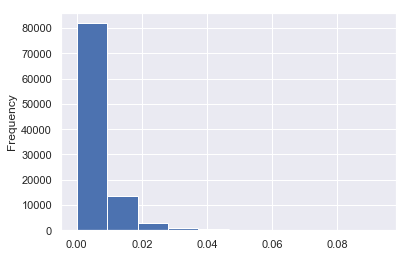

In [19]:
Xscaled.purchase_dayofweek.plot(kind='hist')

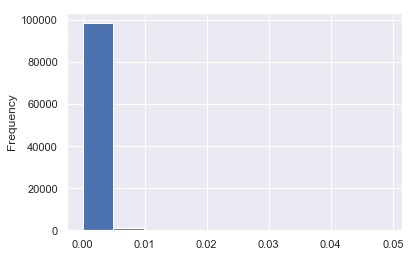

In [20]:
Xscaled.order_freight_ratio.plot(kind='hist')

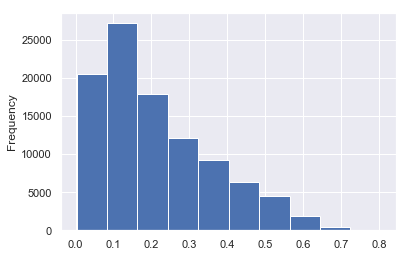

In [21]:
Xscaled.total_order_value.plot(kind='hist')

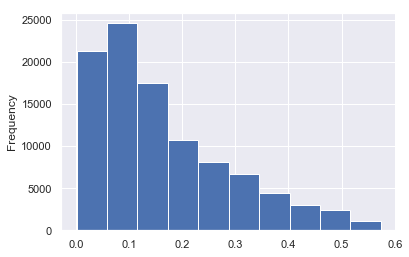

In [22]:
Xscaled.average_product_value.plot(kind='hist')

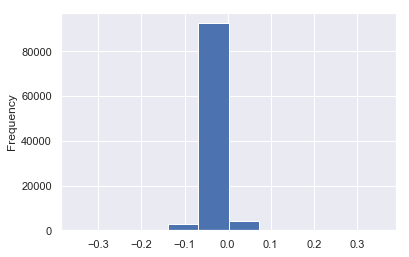

In [23]:
Xscaled.delivery_time_delta_wd.plot(kind='hist')

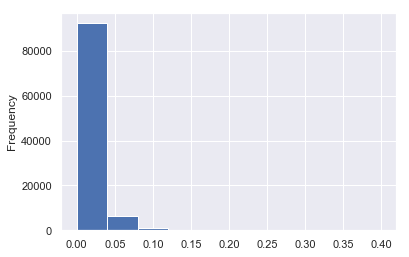

In [24]:
Xscaled.actual_delivery_time_wd.plot(kind='hist')

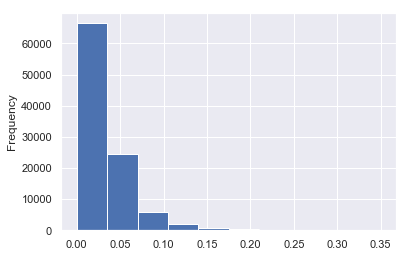

In [25]:
Xscaled.estimated_delivery_time_wd.plot(kind='hist')

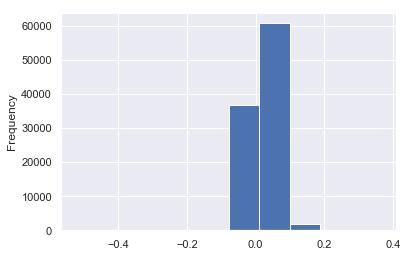

In [26]:
Xscaled.delayed.plot(kind='hist')

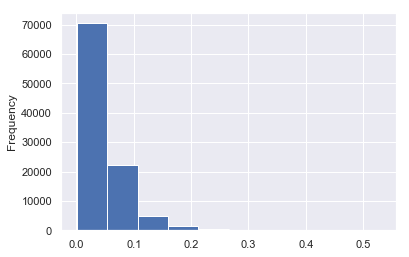

In [27]:
Xscaled.delta_est_delivered.plot(kind='hist')

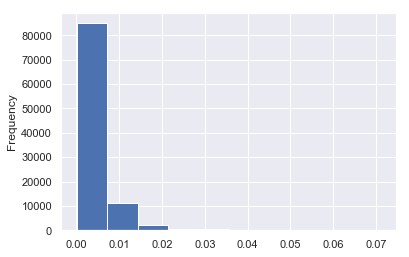

In [28]:
Xscaled.product_photos_qty.plot(kind='hist')

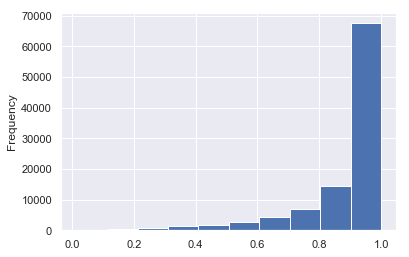

In [29]:
Xscaled.product_description_lenght.plot(kind='hist')

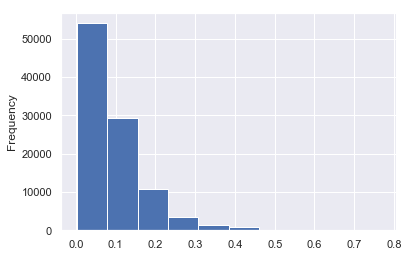

In [30]:
Xscaled.product_name_lenght.plot(kind='hist')

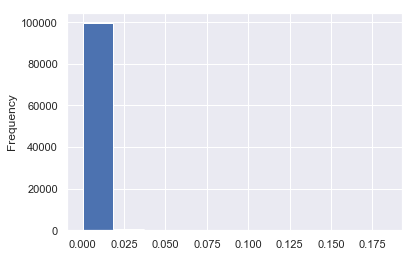

In [31]:
Xscaled.order_sellers_qty.plot(kind='hist')

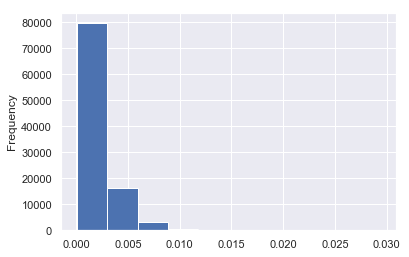

In [32]:
Xscaled.order_items_qty.plot(kind='hist')

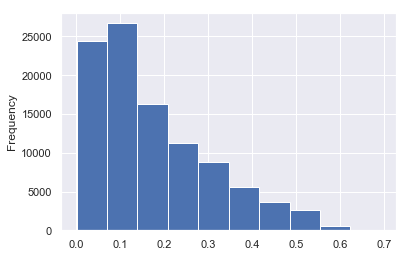

In [33]:
Xscaled.order_products_value.plot(kind='hist')

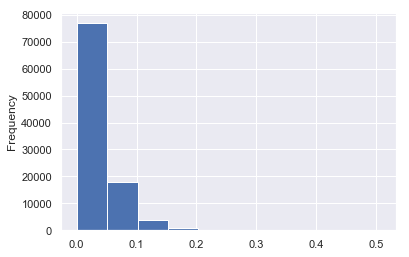

In [34]:
Xscaled.order_freight_value.plot(kind='hist')

In [35]:
orders_FE1.columns

Index(['order_status', 'customer_state', 'customer_city',
       'product_category_name', 'review_score', 'is_late',
       'order_products_value', 'order_freight_value', 'order_items_qty',
       'order_sellers_qty', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty',
       'delta_est_delivered', 'delayed', 'estimated_delivery_time_wd',
       'actual_delivery_time_wd', 'delivery_time_delta_wd',
       'average_product_value', 'total_order_value', 'order_freight_ratio',
       'purchase_dayofweek'],
      dtype='object')

### Split data in train and test sets

In [36]:
# prepare data for Model fit
X=orders_FE1.drop('review_score', axis=1)
y=orders_FE1['review_score']

In [37]:
#Split data in test and train datasets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.85, test_size=0.15, stratify=y)

### Model Selection

We need to select a classifier that performs the best, given the features. We will train our model using three classifiers: __Logistic Regression, Random Forest and Gradient Boosting,__ and choose the one with the best accuracy.

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [39]:
classifiers = [RandomForestClassifier(verbose=1), LogisticRegression(verbose=1), GradientBoostingClassifier(verbose=True)]

for classifier in classifiers:
    classifier.fit(Xtrain, ytrain)
    print("Score: " + str(classifier.score(Xtest, ytest)))

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Score: 0.5526
[LibLinear]Score: 0.5932666666666667
      Iter       Train Loss   Remaining Time 
         1      117621.9038            2.40m
         2      113429.9643            2.47m
         3      110123.9833            2.41m
         4      107478.7404            2.40m
         5      105346.4025            2.46m
         6      103624.0196            2.47m
         7      102201.9202            2.46m
         8      101039.6949            2.47m
         9      100090.6959            2.48m
        10       99317.2877            2.47m
        20       95953.8363            2.24m
        30       94909.1021            2.02m
        40       94361.4998            1.80m
        50       94003.6931            1.49m
        60       93720.4773            1.19m
        70       93463.5145           53.04s
        80       93245.6454           35.16s
        90       93022.0108           17.60s
       100       92813.7198            0.00s
Score: 0.6074


The following results were obtained:

    - Random Forest Classifier is the least accurate classifier with a logged accuracy of 55%.
    - Logistic regression gave an accuracy of 59% 
    - On average, the Gradient Boosting Classifier performed the best with accuracy  60%.
      so I will choose Gradient Boosting Classifier as my model of choice.

### Feature importance

In [58]:
feat_importance = grb_clf.feature_importances_
#sort the feature by importance, from the most important ones to least important ones
feat_imp_sort_ix=feat_importance.argsort()[::-1]
#the most important features are
Xtrain.columns[feat_imp_sort_ix[0:10]]

Index(['delayed', 'order_sellers_qty', 'actual_delivery_time_wd',
       'delivery_time_delta_wd', 'order_items_qty', 'product_name_lenght',
       'product_photos_qty', 'customer_city', 'average_product_value',
       'order_freight_value'],
      dtype='object')

This classifier has an accuracy of approximately 60%. Let us try and improve this by using hyperparameter tuning using Grid Search Cross Validation. Fortunately, like always, scikit-learn has the tools available to us that reduces the amount of code to a bare minimum.

In [41]:
parameters = {
    'n_estimators': [100,200],
    'max_features': ['auto', 'log2'],
    'max_depth': [3,5]
}

In [42]:
clf = GridSearchCV(GradientBoostingClassifier(), parameters, verbose=100)
clf.fit(Xtrain,ytrain)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] max_depth=3, max_features=auto, n_estimators=100 ................
[CV]  max_depth=3, max_features=auto, n_estimators=100, score=0.605294 - 1.8min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s
[CV] max_depth=3, max_features=auto, n_estimators=100 ................
[CV]  max_depth=3, max_features=auto, n_estimators=100, score=0.608160 - 1.8min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.6min remaining:    0.0s
[CV] max_depth=3, max_features=auto, n_estimators=100 ................
[CV]  max_depth=3, max_features=auto, n_estimators=100, score=0.608429 - 1.8min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.4min remaining:    0.0s
[CV] max_depth=3, max_features=auto, n_estimators=200 ................
[CV]  max_depth=3, max_features=auto, n_estimators=200, score=0.604659 - 2.8min
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.3min remaining:    0.0s
[CV] max_depth=3

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200], 'max_features': ['auto', 'log2'], 'max_depth': [3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=100)

In [43]:
clf.best_params_

{'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}

### Testing

In [44]:
grb_clf = GradientBoostingClassifier(verbose=True)

In [45]:
grb_clf.fit(Xtrain, ytrain)

      Iter       Train Loss   Remaining Time 
         1      117621.9038            1.45m
         2      113429.9643            1.45m
         3      110123.9833            1.42m
         4      107478.7404            1.40m
         5      105346.4025            1.38m
         6      103624.0196            1.37m
         7      102201.9202            1.36m
         8      101039.6949            1.34m
         9      100090.6959            1.32m
        10       99317.2877            1.31m
        20       95953.8363            1.17m
        30       94909.1021            1.03m
        40       94361.4998           52.66s
        50       94003.6931           43.64s
        60       93720.4773           34.80s
        70       93463.5145           25.98s
        80       93245.6454           17.22s
        90       93022.0108            8.60s
       100       92813.7198            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0,
              verbose=True, warm_start=False)

In [46]:
score=grb_clf.score(Xtest,ytest)
score

0.6074

In [47]:
y_pred_class = grb_clf.predict(Xtest)

In [48]:
np.unique(y_pred_class)

array([1, 2, 3, 4, 5], dtype=int64)

### Confusion Matrix

In [49]:
print(metrics.confusion_matrix(ytest, y_pred_class))

[[ 774    3    3    0 1006]
 [ 114    0    0    1  397]
 [ 127    0    0    0 1184]
 [ 100    0    0    1 2786]
 [ 164    2    0    2 8336]]


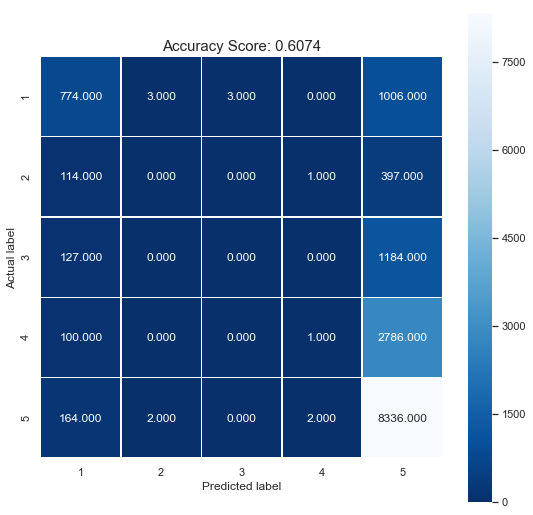

In [50]:
#redictions = grb_clf.predict(Xtest)
cm = metrics.confusion_matrix(ytest, y_pred_class)
xticks = [1,2,3,4,5]
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r',xticklabels=xticks,yticklabels=xticks);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [52]:
pred_prob = classifier.predict_proba(Xtest)

In [53]:
pred_prob = pd.DataFrame(pred_prob, index=Xtest.index)
pred_prob.head()

,0,1,2,3,4
8240,0.071563,0.036413,0.101058,0.221627,0.569340
38575,0.076790,0.034727,0.101449,0.237088,0.549945
72830,0.069757,0.030735,0.090745,0.210325,0.598438
16639,0.058757,0.027120,0.081112,0.196616,0.636394
47220,0.617809,0.071213,0.087667,0.083525,0.139786


In [54]:
indexes = [i for i in range(1,6)]
indexes

[1, 2, 3, 4, 5]

In [55]:
classes = [1,2,3,4,5]
classes[0]

1

In [56]:
def get_top(s):
    indexes = [i for i in range(0,5)]
    lst = list(zip(indexes, s))
    top_five = sorted(lst, key=lambda x: x[1], reverse=True)[:5]
    top_five = [classes[i[0]] for i in top_five]
    return top_five

In [57]:
pred_prob['get_top'] = pred_prob.apply(get_top, axis=1)
pred_prob.head()

,0,1,2,3,4,get_top
8240,0.071563,0.036413,0.101058,0.221627,0.569340,"[5, 4, 3, 1, 2]"
38575,0.076790,0.034727,0.101449,0.237088,0.549945,"[5, 4, 3, 1, 2]"
72830,0.069757,0.030735,0.090745,0.210325,0.598438,"[5, 4, 3, 1, 2]"
16639,0.058757,0.027120,0.081112,0.196616,0.636394,"[5, 4, 3, 1, 2]"
47220,0.617809,0.071213,0.087667,0.083525,0.139786,"[1, 5, 3, 4, 2]"
